In [ ]:
# Discard the output of this cell.
%%capture

!pip install vit-pytorch

In [2]:
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from glob import glob

Reproducibility

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

## Dataset

In [3]:
PATH_DATASET_DIR = "/kaggle/input/ucf50-action-recognition-dataset/UCF50"
HEIGHT, WIDTH = 240, 320
SEQUENCE_LENGTH = 20

videos = glob(f"{PATH_DATASET_DIR}/**/*.avi")
labels = [path.replace(f"{PATH_DATASET_DIR}/", "") for path in glob(f"{PATH_DATASET_DIR}/**")]

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
from torch.utils.data import Dataset
import cv2

class VideoDataset(Dataset):
    
    def __init__(self, video_paths, transform=None, num_videos=None, num_frames=None):
        self.video_paths = video_paths
        self.transform = transform
        self.lab2idx = {}
        
        if num_videos is not None:
            labels = set([path.split("/")[-2] for path in video_paths])
            self.lab2idx = { w : i for i, w in enumerate(labels) } 
            buffer = []
            for label in labels:
                videos = []
                for path in video_paths:
                    if label in path:
                        videos.append(path)
                videos = np.random.choice(videos, num_videos)
                buffer.extend(videos)
            self.paths = buffer
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        video_path = self.paths[idx]
        label = video_path.split("/")[-2]
        frames = self.read_video(video_path)
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])
        else:
            frames = torch.stack(frames)
        return frames, self.lab2idx[label]
    
    def read_video(self, video_path):
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        window = max(int(frames_count/SEQUENCE_LENGTH), 1)
        
        for i in range(SEQUENCE_LENGTH):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * window)
            ret, frame = cap.read()
            if not ret:
                break
            fixed_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
            
        cap.release()
        return np.array(frames)

In [6]:
dataset = VideoDataset(videos, transform, 100)

### Train and test split

In [7]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### Transform and train dataloader

In [15]:
batch_size = 4
num_workers = os.cpu_count()
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle = True, batch_size = batch_size, drop_last = True, num_workers = num_workers)

### Transform and test data loader

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, drop_last = True, num_workers = num_workers)

## Necessary functions

### Evaluate function

In [10]:
def evaluate(model, val_data, loss_fn, weights = None, device = 'cpu', verbose = 0):
    
    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')
    
    model = model.to(device)

    if weights:
        model.load_state_dict(torch.load(weights))
    
    with torch.no_grad():
        model.eval()
        val_correct = 0
        val_total = len(val_data)*val_data.batch_size
        running_loss = 0.
        if verbose == 1:
            val_data = tqdm(val_data, desc = 'Evaluate: ', ncols = 100)
        for data_batch, label_batch in val_data:
            
            data_batch, label_batch = data_batch.to(device), label_batch.to(device)
            output_batch = model(data_batch.reshape([-1, 3, 20, 240, 240]))
            loss = loss_fn(output_batch, label_batch.long())
            running_loss += loss.item()

            _, predicted_labels = torch.max(output_batch.data, dim = 1)

            val_correct += (label_batch == predicted_labels).sum().item()
        val_loss = running_loss/len(val_data)
        val_acc = val_correct/val_total
        return val_loss, val_acc


### Train function

In [11]:
def train(model, train_data, val_data, loss_fn, optimizer, epochs, save_last_weights_path = None,
          save_best_weights_path = None, freeze = False, steps_per_epoch = None,
          device = 'cpu', scheduler = None):

    if (device == 'gpu' or device == 'cuda') and torch.cuda.is_available():
        device = torch.device('cuda')
    elif isinstance(device, torch.device): 
        device = device
    else: 
        device = torch.device('cpu')        

    if save_best_weights_path: 
        best_loss, _ = evaluate(model, val_data, device = device, loss_fn = loss_fn, verbose = 1)  

    if steps_per_epoch is None: 
        steps_per_epoch = len(train_data)

    num_steps = len(train_data)
    iterator = iter(train_data)
    count_steps = 1    
    
    ## History
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_loss': []
    }
        
    # add model to device
    model = model.to(device)
    
    ############################### Train and Val ##########################################
    for epoch in range(1, epochs + 1):

        running_loss = 0.
        train_correct = 0
        train_total = steps_per_epoch*train_data.batch_size
        
        model.train()
        
        for step in tqdm(range(steps_per_epoch), desc = f'epoch: {epoch}/{epochs}: ', ncols = 100): 
            
            img_batch, label_batch = next(iterator)
            img_batch, label_batch = img_batch.to(device), label_batch.to(device)

            optimizer.zero_grad()

            output_batch = model(img_batch.reshape([-1, 3, 20, 240, 240]))

            loss = loss_fn(output_batch, label_batch.long())
            loss.backward()
            optimizer.step()

            _, predicted_labels = torch.max(output_batch.data, dim = 1)
            train_correct += (label_batch == predicted_labels).sum().item()
            running_loss += loss.item()
                
            if count_steps == num_steps:
                count_steps = 0
                iterator = iter(train_data)
            count_steps += 1
            
        train_loss = running_loss / steps_per_epoch
        train_accuracy = train_correct/train_total
        
        if scheduler:
            scheduler.step(train_loss)
        
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_accuracy))
        
        if val_data is not None: 
            val_loss, val_acc = evaluate(model, val_data, device = device, loss_fn = loss_fn)
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}, val_accuracy: {val_acc: .2f}, val_loss: {val_loss:.3f}')

            if save_best_weights_path:
                if val_loss < best_loss:
                    best_loss = val_loss
                    torch.save(model.state_dict(), save_best_weights_path)
                    print(f'Saved successfully best weights to:', save_best_weights_path)
            history['val_loss'].append(float(val_loss))
            history['val_acc'].append(float(val_acc))
        else:
            print(f'epoch: {epoch}, train_accuracy: {train_accuracy: .2f}, loss: {train_loss: .3f}')
    if save_last_weights_path:  
        torch.save(model.state_dict(), save_last_weights_path)
        print(f'Saved successfully last weights to:', save_last_weights_path)
    return model, history


### Visualize history

In [13]:
def visualize_history(history, metrics = ['acc', 'loss']):   
    
    if 'acc' in metrics:
        plt.figure(figsize = (10,6))
        plt.subplot(121)
        plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label = 'train_acc', c = 'r')
        plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label = 'val_acc', c = 'g')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    if 'loss' in metrics:
        plt.subplot(122)
        plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label = 'train_loss', c = 'r')
        plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label = 'val_loss', c = 'g')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

## Model

### Parameters

In [14]:
mode = 'train'
last_weights = 'last_weights.pt'
best_weights = 'best_weights.pt'

num_classes = 50
num_frames = SEQUENCE_LENGTH
device = 'cuda' if torch.cuda.is_available() else 'cpu'
hidden_size = 128
num_lstm_layers = 2

### Create model

In [16]:
from vit_pytorch.vit_3d import ViT

model = ViT(
    image_size = 240,          # image size
    frames = 20,               # number of frames
    image_patch_size = 16,     # image patch size
    frame_patch_size = 2,      # frame patch size
    num_classes = 50,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, mode = 'min', patience = 3, verbose = 1)

## Train model

In [17]:
model, history = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs = 50,
              save_last_weights_path = last_weights, save_best_weights_path = best_weights,
              device = device, scheduler = scheduler)


epoch: 1/50: 100%|████████████████████████████████████████████████| 875/875 [09:31<00:00,  1.53it/s]


epoch: 1, train_accuracy:  0.09, loss:  3.595, val_accuracy:  0.13, val_loss: 3.235
Saved successfully best weights to: best_weights.pt


epoch: 2/50: 100%|████████████████████████████████████████████████| 875/875 [09:31<00:00,  1.53it/s]


epoch: 2, train_accuracy:  0.21, loss:  2.905, val_accuracy:  0.27, val_loss: 2.750
Saved successfully best weights to: best_weights.pt


epoch: 3/50: 100%|████████████████████████████████████████████████| 875/875 [09:31<00:00,  1.53it/s]


epoch: 3, train_accuracy:  0.33, loss:  2.403, val_accuracy:  0.36, val_loss: 2.433
Saved successfully best weights to: best_weights.pt


epoch: 4/50: 100%|████████████████████████████████████████████████| 875/875 [09:31<00:00,  1.53it/s]


epoch: 4, train_accuracy:  0.44, loss:  1.956, val_accuracy:  0.46, val_loss: 2.045
Saved successfully best weights to: best_weights.pt


epoch: 5/50: 100%|████████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 5, train_accuracy:  0.57, loss:  1.513, val_accuracy:  0.52, val_loss: 1.886
Saved successfully best weights to: best_weights.pt


epoch: 6/50: 100%|████████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 6, train_accuracy:  0.66, loss:  1.173, val_accuracy:  0.55, val_loss: 1.738
Saved successfully best weights to: best_weights.pt


epoch: 7/50: 100%|████████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 7, train_accuracy:  0.74, loss:  0.885, val_accuracy:  0.62, val_loss: 1.557
Saved successfully best weights to: best_weights.pt


epoch: 8/50: 100%|████████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 8, train_accuracy:  0.81, loss:  0.648, val_accuracy:  0.63, val_loss: 1.551
Saved successfully best weights to: best_weights.pt


epoch: 9/50: 100%|████████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 9, train_accuracy:  0.84, loss:  0.521, val_accuracy:  0.64, val_loss: 1.553


epoch: 10/50: 100%|███████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 10, train_accuracy:  0.87, loss:  0.429, val_accuracy:  0.62, val_loss: 1.766


epoch: 11/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 11, train_accuracy:  0.87, loss:  0.431, val_accuracy:  0.65, val_loss: 1.596


epoch: 12/50: 100%|███████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 12, train_accuracy:  0.91, loss:  0.315, val_accuracy:  0.62, val_loss: 1.925


epoch: 13/50: 100%|███████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 13, train_accuracy:  0.91, loss:  0.310, val_accuracy:  0.65, val_loss: 1.645


epoch: 14/50: 100%|███████████████████████████████████████████████| 875/875 [09:32<00:00,  1.53it/s]


epoch: 14, train_accuracy:  0.90, loss:  0.317, val_accuracy:  0.63, val_loss: 1.702


epoch: 15/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 15, train_accuracy:  0.93, loss:  0.237, val_accuracy:  0.68, val_loss: 1.523
Saved successfully best weights to: best_weights.pt


epoch: 16/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 16, train_accuracy:  0.91, loss:  0.279, val_accuracy:  0.64, val_loss: 1.871


epoch: 17/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 17, train_accuracy:  0.90, loss:  0.294, val_accuracy:  0.66, val_loss: 1.750


epoch: 18/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 18, train_accuracy:  0.93, loss:  0.246, val_accuracy:  0.68, val_loss: 1.649


epoch: 19/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 19, train_accuracy:  0.93, loss:  0.235, val_accuracy:  0.61, val_loss: 1.937


epoch: 20/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 20, train_accuracy:  0.91, loss:  0.265, val_accuracy:  0.66, val_loss: 1.753


epoch: 21/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 21, train_accuracy:  0.90, loss:  0.316, val_accuracy:  0.68, val_loss: 1.746


epoch: 22/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 22, train_accuracy:  0.92, loss:  0.265, val_accuracy:  0.66, val_loss: 1.818


epoch: 23/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


epoch: 23, train_accuracy:  0.93, loss:  0.244, val_accuracy:  0.69, val_loss: 1.719


epoch: 24/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 24, train_accuracy:  0.98, loss:  0.088, val_accuracy:  0.71, val_loss: 1.486
Saved successfully best weights to: best_weights.pt


epoch: 25/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 25, train_accuracy:  0.99, loss:  0.047, val_accuracy:  0.71, val_loss: 1.509


epoch: 26/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 26, train_accuracy:  0.99, loss:  0.031, val_accuracy:  0.72, val_loss: 1.500


epoch: 27/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 27, train_accuracy:  1.00, loss:  0.021, val_accuracy:  0.73, val_loss: 1.518


epoch: 28/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 28, train_accuracy:  1.00, loss:  0.014, val_accuracy:  0.73, val_loss: 1.493


epoch: 29/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 29, train_accuracy:  1.00, loss:  0.015, val_accuracy:  0.72, val_loss: 1.502


epoch: 30/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 30, train_accuracy:  1.00, loss:  0.012, val_accuracy:  0.73, val_loss: 1.534


epoch: 31/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 31, train_accuracy:  1.00, loss:  0.012, val_accuracy:  0.72, val_loss: 1.534


epoch: 32/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 32, train_accuracy:  1.00, loss:  0.011, val_accuracy:  0.73, val_loss: 1.536


epoch: 33/50: 100%|███████████████████████████████████████████████| 875/875 [09:34<00:00,  1.52it/s]


epoch: 33, train_accuracy:  1.00, loss:  0.007, val_accuracy:  0.74, val_loss: 1.582


epoch: 34/50: 100%|███████████████████████████████████████████████| 875/875 [09:34<00:00,  1.52it/s]


epoch: 34, train_accuracy:  1.00, loss:  0.007, val_accuracy:  0.73, val_loss: 1.602


epoch: 35/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 35, train_accuracy:  1.00, loss:  0.005, val_accuracy:  0.74, val_loss: 1.584


epoch: 36/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 36, train_accuracy:  1.00, loss:  0.007, val_accuracy:  0.73, val_loss: 1.550


epoch: 37/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 37, train_accuracy:  1.00, loss:  0.005, val_accuracy:  0.73, val_loss: 1.556


epoch: 38/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 38, train_accuracy:  1.00, loss:  0.004, val_accuracy:  0.73, val_loss: 1.580


epoch: 39/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 39, train_accuracy:  1.00, loss:  0.005, val_accuracy:  0.73, val_loss: 1.589


epoch: 40/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 40, train_accuracy:  1.00, loss:  0.003, val_accuracy:  0.74, val_loss: 1.612


epoch: 41/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 41, train_accuracy:  1.00, loss:  0.003, val_accuracy:  0.74, val_loss: 1.610


epoch: 42/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 42, train_accuracy:  1.00, loss:  0.003, val_accuracy:  0.74, val_loss: 1.653


epoch: 43/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 43, train_accuracy:  1.00, loss:  0.003, val_accuracy:  0.74, val_loss: 1.684


epoch: 44/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.52it/s]


epoch: 44, train_accuracy:  1.00, loss:  0.002, val_accuracy:  0.74, val_loss: 1.708


epoch: 45/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 45, train_accuracy:  1.00, loss:  0.004, val_accuracy:  0.74, val_loss: 1.702


epoch: 46/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 46, train_accuracy:  1.00, loss:  0.002, val_accuracy:  0.73, val_loss: 1.669


epoch: 47/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 47, train_accuracy:  1.00, loss:  0.002, val_accuracy:  0.73, val_loss: 1.674


epoch: 48/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 48, train_accuracy:  1.00, loss:  0.003, val_accuracy:  0.73, val_loss: 1.696


epoch: 49/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 49, train_accuracy:  1.00, loss:  0.002, val_accuracy:  0.73, val_loss: 1.722


epoch: 50/50: 100%|███████████████████████████████████████████████| 875/875 [09:33<00:00,  1.53it/s]


epoch: 50, train_accuracy:  1.00, loss:  0.002, val_accuracy:  0.74, val_loss: 1.714
Saved successfully last weights to: last_weights.pt


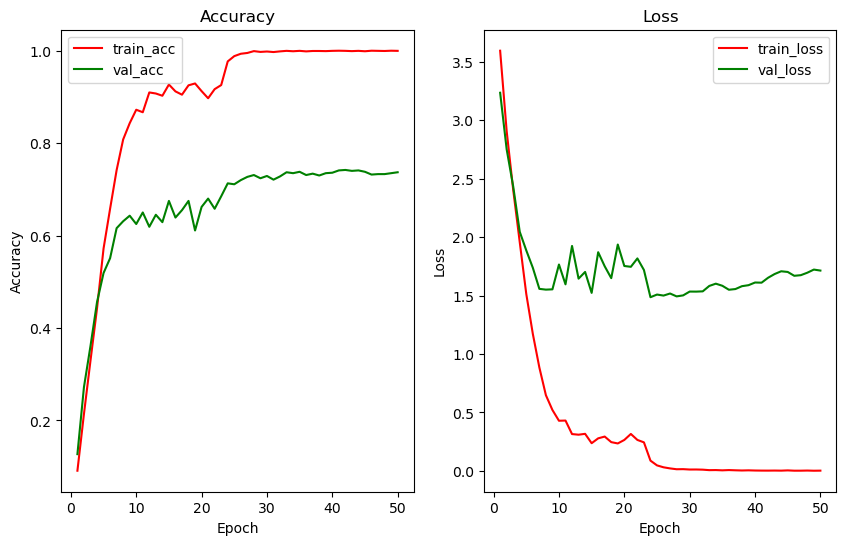

In [18]:
visualize_history(history)

## Test Model

In [20]:
test_loss, test_acc = evaluate(model, weights = last_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Evaluate: 100%|███████████████████████████████████████████████████| 125/125 [00:39<00:00,  3.20it/s]

Loss:  1.506, Acc:  0.742


In [21]:
test_loss, test_acc = evaluate(model, weights = best_weights, val_data = test_dataloader, loss_fn = loss_fn, device = 'cuda', verbose = 1)
print(f'Loss: {test_loss : .3f}, Acc: {test_acc: .3f}')

Evaluate: 100%|███████████████████████████████████████████████████| 125/125 [00:37<00:00,  3.33it/s]

Loss:  1.339, Acc:  0.730
